# BLIP vs CLIP Comparison

## Quick Rundown
- CLIP is a multi-modal language model trained on parings between text and images to learn a joint representation of the two modalities. This allows for direct comparison between images and text using similarity metrics like cosine similarity. However, this narrowly defined objective prevents CLIP from being used as a standalone reasoning model.
    - Flamingo is a more generally capable model that builds directly off of CLIP, sharing a hidden dimension of 1024. It can account for arbitrary length sequences with its perceiver architecture, which maintains the arbitrary length input for the purposes of cross attention with a fixed-size latent bottleneck; a fixed number of repeats of alternating cross attention and self attention layers are used to "copy" all of the relevant from the input into the latent space which goes on to be processed by the rest of the model.
- BLIP-2 is a multi-modal language model with more general capabilities than CLIP, but which does not learn a joint representation of text and images. Instead, it uses a querying transformer, which is composed of two transformer blocks. One block takes learned queries as input and cross-attends with the output of a frozen (and swappable) image encoder, while the other is a simple text transformer. Essentially, what this does is map from a pre-existing semantic space for images and a pre-existing semantic space for text into a learned internal representation trained to extract the information from the image most relevant to the text. This internal representation is then passed to the model's decoder. This architecture is highly modular as the image encoder, text encoder, and general decoder can all be swapped out for different models.
    - In the 3D-LLM paper, they opt to use the T5 text encoder due to its greater representational ability, and an expanded CLIP image encoder (EVA_CLIP) with a larger feature dimension and a special positional encoding to represent the 3d space in which the points live. The positional encoding is left unfrozen during fine-tuning to allow the model to learn spatial reasoning.
    - The querying transformer architecture also allows BLIP-2 to handle arbitrarily sized multimodal inputs.
- Flamingo is a multi-modal language model that preceded BLIP-2 

## Section 1: Question answering
The images below are captured directly from Mujoco, the simulator used by the RoCo paper. The use of that simulator allows me to bypass the doing image segmentation and point cloud reconstruction myself, which saves crucial compute resources; the simulator has built in methods to segment 2d camera renders by objects specified by tags in the xml file, which makes getting object specific pictures and determing which point cloud points correspond to what object trivial.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import gc
plt.clf()
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']

In [ ]:
# BLIP captioning
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoProcessor
import torch

class Blip2:
    def __init__(self, device_id):
        self.device = "cuda:{}".format(device_id)

        self.blip2_processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
        self.blip2 = Blip2ForConditionalGeneration.from_pretrained(
            "Salesforce/blip2-flan-t5-xl", device_map={"": device_id}, torch_dtype=torch.float16
        )

    def ask(self, raw_image, question):
        inputs = self.blip2_processor(raw_image, question, return_tensors="pt").to(self.device, torch.float16)
        out = self.blip2.generate(**inputs)
        answer = self.blip2_processor.decode(out[0], skip_special_tokens=True)
        return answer
    
    def nucleus_ask(self, raw_image, question):
        inputs = self.blip2_processor(raw_image, question, return_tensors="pt").to(self.device, torch.float16)
        # print(self.blip2)
        print(inputs)
        generated_ids = self.blip2.generate(
            **inputs,
            # pixel_values=inputs.pixel_values,
            do_sample="Nucleus sampling",
            temperature=0.5,
            length_penalty=-1.0,
            repetition_penalty=1.0,
            max_length=30,
            min_length=1,
            num_beams=5,
            top_p=0.1
        )
        print(generated_ids)
        result = self.blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return result

    def caption(self, raw_image, mode="default"):
        if mode == "default":
            # starndard way to caption an image in the blip2 paper
            caption = self.ask(raw_image, "a photo of")
            caption = caption.replace("\n", " ").strip()  # trim caption
        elif mode == "nucleus":
            caption = self.nucleus_ask(raw_image, "a photo of")
        return caption
    
blip2_inst = Blip2(0)

blip_captions = {cam_name: blip2_inst.caption(outputs[cam_name]) for cam_name in point_feature_cameras}

# Clean up
blip2_inst = None
del blip2_inst
gc.collect()

<Figure size 640x480 with 0 Axes>

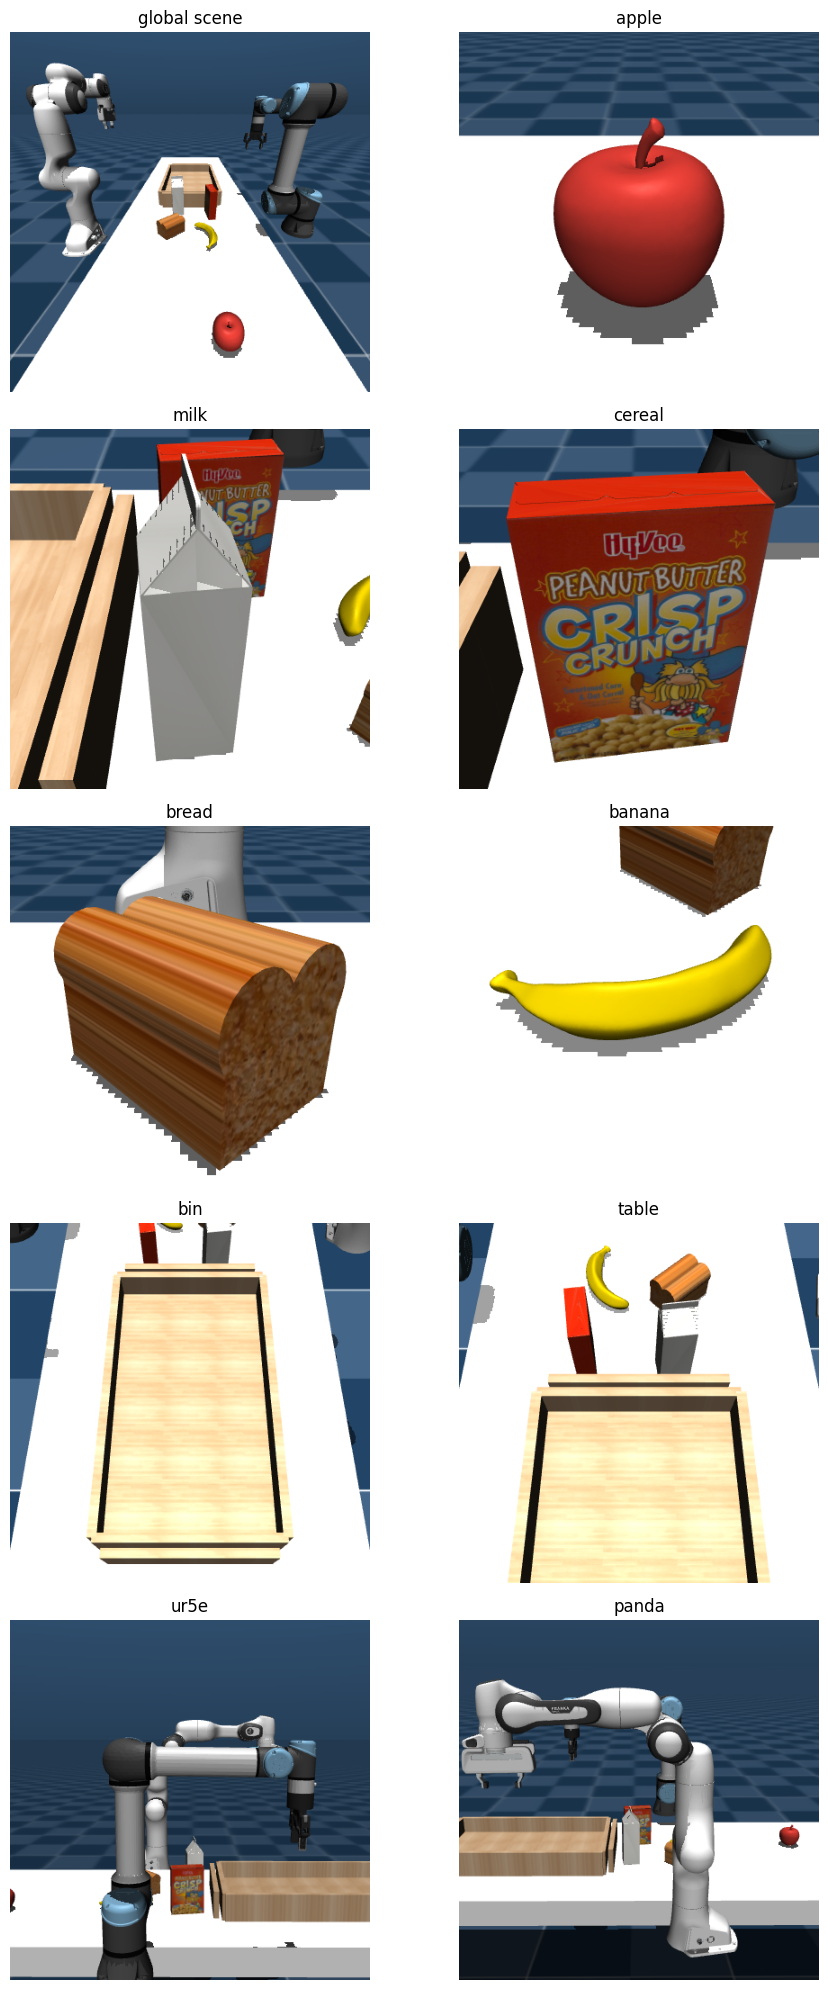

In [15]:
fig, ax = plt.subplots(10,2, figsize=(10, 20))

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']
for i, point_feature_camera in enumerate(point_feature_cameras):
    ax[i,0].imshow(outputs[point_feature_camera])
    ax[i,0].set_title(point_feature_camera if point_feature_camera != 'sceneshotcam' else 'global scene')
    ax[i,0].axis('off')
plt.tight_layout()
plt.show()

### BLIP-2 Question Answering